# Introduction to Deep Learning
## Assignment 3
### Task 1: Recurrent Neural Networks
<img src="https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg" width="500"> 

The goal of this task is to learn how to use encoder-decoder recurrent models. Specifically we will be dealing with a sequence to sequence problem and try to develop a neural network that can learn the principles behind simple arithmetic operations.



To work on this notebook you should create a copy of it.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose, Conv3DTranspose

# Function definitions for creating the dataset

In order to create image queries of simple arithmetic operations such as '51+31' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset.

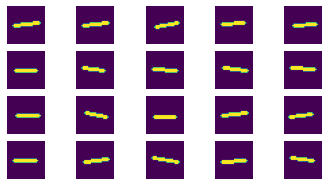

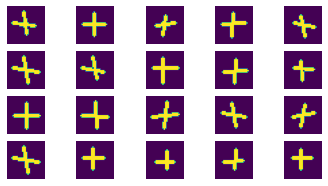

In [ ]:
# Create plus/minus signs
def generate_images(cross=False, n=50):
    x = np.random.randint(12, 16, (n, 2))
    y1 = np.random.randint(4, 8, n)
    y2 = np.random.randint(20, 24, n)
    
    blank = np.zeros([n, 28, 28])
    for i in range(n):
        line = cv2.line(blank[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)
        if cross:
            line = cv2.line(blank[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank

def show_generated(images):
    for i in range(20):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(cross=True))

In [ ]:
import random

def create_data(highest_integer):
    """
    Creates the following data for all pairs of integers up to [highest integer]+[highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28)
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]   #includes the indices of each digit in the MNIST dataset
    num_data = [MNIST_data[inds] for inds in num_indices]   #the images, note they are ordered here according to string, i.e the same strings are grouped together
    image_mapping = dict(zip(unique_characters[:10], num_data))  #create a dictionary for all the images
    image_mapping['-'] = generate_images()  #produce - images
    image_mapping['+'] = generate_images(cross=True)  #produce + images
    image_mapping[' '] = np.zeros([1, 28, 28])   #blank image

    X_text, X_img, y_text, y_img = [], [], [], []    #lists of interest
    for i in range(highest_integer + 1):
        for j in range(highest_integer + 1):
            
            i_char = to_padded_chars(i, max_len=max_int_length)
            j_char = to_padded_chars(j, max_len=max_int_length)

            for sign in ['-', '+']:
                query_string = i_char + sign + j_char
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))
            
    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.
  
def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 80000 samples that have two kinds of inputs and labels:

  X_text: strings containing queries of length 7: ['  1+  1', '174- 18', ...] 

  X_image: a stack of images representing a single query, dimensions: [7, 28, 28]

  y_text: strings containing answers of length 4: ['   2', ' 156']

  y_image: a stack of images that represents the answer to a query, dimensions: [4, 28, 28]

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- ' # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 199 # Highest value of integers contained in the queries
max_int_length = len(str(highest_integer)) # 
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = max_int_length + 1    # Maximum length of the answer string

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labs = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.title(labs[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
        print(np.hstack(data[n]).shape)
    print('='*50, f'\nSample ID: {n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 80000, 1)[0])

11501568/11490434 [==============================] - 0s 0us/step
(80000,) (80000, 7, 28, 28) (80000,) (80000, 4, 28, 28)


# Our code begins here!

In [ ]:
#Note this cell is our own code!!!!!
#Shuffle the data so that the initial order is destroyed
from sklearn.utils import shuffle

X_text, y_text, X_img, y_img = shuffle(X_text, y_text, X_img, y_img, random_state = 0)

In [ ]:
#we saved all the training and test data, here we upload them

from google.colab import drive
drive.mount('/content/gdrive')

X_img = np.load('/content/gdrive/MyDrive/X_img.npy')                #input images
y_img = np.load('/content/gdrive/MyDrive/y_img.npy')                #output images
X_text = np.load('/content/gdrive/MyDrive/X_text.npy')              #input text
y_text = np.load('/content/gdrive/MyDrive/y_text.npy')              #output text
X_text_onehot = np.load('/content/gdrive/MyDrive/X_text_onehot.npy')#input text in one-hot format
y_text_onehot = np.load('/content/gdrive/MyDrive/y_text_onehot.npy')#output text in one-hot format

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Create training and test sets
ratio = 0.2. #how training and test set is split
u = int(len(X_text_onehot) * ratio)
X_text_onehot_train, X_text_onehot_test = X_text_onehot[u:], X_text_onehot[:u]
y_text_onehot_train, y_text_onehot_test = y_text_onehot[u:], y_text_onehot[:u]
X_img_train, X_img_test = X_img[u:], X_img[:u]
y_img_train, y_img_test = y_img[u:], y_img[:u]

---
---

# 1. Text-to-text RNN model

The following code showcases how Recurrent neural networks are built using Keras. Several new layers are going to be used:

1. LSTM 
2. TimeDistributed
3. RepeatVector

The following code shows the basic architecture of a Recurrent Neural Network
LSTM (Long Short Term Memory) layers can be replaced either with SimpleRNN or GRU (Gated Recurrent Units).



<img src="https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg" width="500"> 


In [ ]:
# We start by initializing a sequential model
text2text = tf.keras.Sequential()

# "Encode" the input sequence using an RNN, producing an output of size 256.
# In this case the size of our input vectors is [7, 13] as we have queries of length 7 and 13 unique characters. Each of these 7 elements in the query will be fed to the network one by one,
# as shown in the image above (except with 7 elements).
# Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
text2text.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))

# As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 4 times as that's the maximum length of the output (e.g. '  1-199' = '-198')
# when using 3-digit integers in queries. In other words, the RNN will always produce 4 characters as its output.
text2text.add(RepeatVector(max_answer_length))

# By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
# the first dimension to be the timesteps.
text2text.add(LSTM(128, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

# Next we compile the model using categorical crossentropy as our loss function.
text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
text2text.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 156)               106080    
                                                                 
 repeat_vector_2 (RepeatVect  (None, 4, 156)           0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 4, 28)             20720     
                                                                 
 time_distributed_2 (TimeDis  (None, 4, 13)            377       
 tributed)                                                       
                                                                 
Total params: 127,177
Trainable params: 127,177
Non-trainable params: 0
_________________________________________________________________


### Your tasks:


In [ ]:
# Train and experiment with the text-to-text RNN Model by using X_text and y_text as your inputs/outputs
# 1. Try different ratios of train/test splits
# 2. Try to find more optimal architectures

history = text2text.fit(X_text_onehot_train, y_text_onehot_train, epochs = 12, batch_size = 64, validation_data = (X_text_onehot_test, y_text_onehot_test))


Epoch 1/12
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3266 - accuracy: 0.9089 - val_loss: 0.2766 - val_accuracy: 0.9331
Epoch 2/12
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2356 - accuracy: 0.9536 - val_loss: 0.1989 - val_accuracy: 0.9661
Epoch 3/12
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1792 - accuracy: 0.9696 - val_loss: 0.1561 - val_accuracy: 0.9737
Epoch 4/12
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1345 - accuracy: 0.9789 - val_loss: 0.1222 - val_accuracy: 0.9799
Epoch 5/12
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1041 - accuracy: 0.9835 - val_loss: 0.0849 - val_accuracy: 0.9892
Epoch 6/12
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0806 - accuracy: 0.9871 - val_loss: 0.0785 - val_accuracy: 0.9858
Epoch 7/12
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0678 - accuracy: 0.9884 - val_loss: 0.0522 - val_accuracy:

In [ ]:
#Assessing the accuracy of the text-to-text model

pred = text2text.predict(X_text_onehot_test)
y_pred = []
for p in pred:
  y = decode_labels(p)
  y_pred.append(y)

count = 0
for i in range(len(y_pred)):
  u, v = y_pred[i], y_text[i]
  if u == v:
    count += 1
print('Accuracy: ', count / len(y_pred))


Accuracy:  0.96125


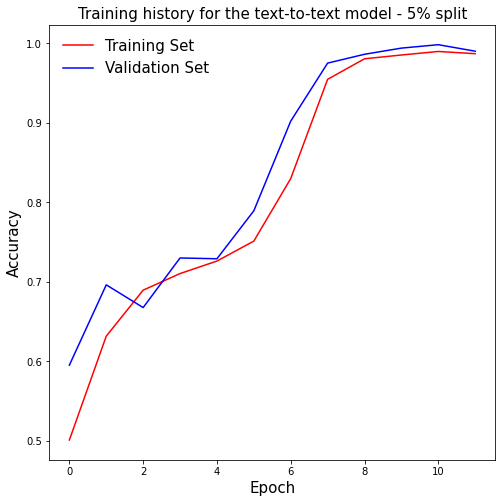

In [ ]:
#plotting the training history of the model

fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(history.history['accuracy'], color = 'red', label = 'Training Set')
ax.plot(history.history['val_accuracy'], color = 'blue', label = 'Validation Set')
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_title('Training history for the text-to-text model - 5% split', fontsize = 15)
ax.legend(frameon = False, fontsize = 15)
#plt.savefig('text2text_0.05_split.pdf')
plt.show()


---
---

# 2. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use X_img as inputs and y_text as outputs.

In [ ]:
# Your code
#architecture of the image-to-text model


image2text = tf.keras.Sequential()
image2text.add(LSTM(256, input_shape=(max_query_length, 784)))
image2text.add(RepeatVector(max_answer_length))
image2text.add(LSTM(128, return_sequences=True))
image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

image2text.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 26, 26, 32)        38144     
                                                                 
 flatten_2 (Flatten)         (None, 21632)             0         
                                                                 
 repeat_vector_5 (RepeatVect  (None, 4, 21632)         0         
 or)                                                             
                                                                 
 time_distributed_5 (TimeDis  (None, 4, 13)            281229    
 tributed)                                                       
                                                                 
Total params: 319,373
Trainable params: 319,373
Non-trainable params: 0
_________________________________________________________________


"\nimage2text = tf.keras.Sequential()\nimage2text.add(LSTM(256, input_shape=(max_query_length, 784)))\n\n\nimage2text.add(RepeatVector(max_answer_length))\n\n\nimage2text.add(LSTM(128, return_sequences=True))\n\n\nimage2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))\n\n\nimage2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\n\nimage2text.summary()\n"

In [ ]:
#we need to create to flatten the images in order to train this network

train = X_img_train.flatten().reshape(64000, 7, 784) #training set 
test = X_img_test.flatten().reshape(16000, 7, 784)   #test/validation set

In [ ]:
history = image2text.fit(train, y_text_onehot_train, epochs = 100, batch_size = 256, validation_data = (test, y_text_onehot_test))

Epoch 1/100
250/250 [==============================] - 11s 30ms/step - loss: 1.5211 - accuracy: 0.4154 - val_loss: 1.3445 - val_accuracy: 0.4608
Epoch 2/100
250/250 [==============================] - 6s 25ms/step - loss: 1.2911 - accuracy: 0.4892 - val_loss: 1.2736 - val_accuracy: 0.4959
Epoch 3/100
250/250 [==============================] - 6s 25ms/step - loss: 1.2354 - accuracy: 0.5169 - val_loss: 1.2289 - val_accuracy: 0.5138
Epoch 4/100
250/250 [==============================] - 6s 25ms/step - loss: 1.1900 - accuracy: 0.5372 - val_loss: 1.1808 - val_accuracy: 0.5408
Epoch 5/100
250/250 [==============================] - 6s 24ms/step - loss: 1.1409 - accuracy: 0.5573 - val_loss: 1.1365 - val_accuracy: 0.5560
Epoch 6/100
250/250 [==============================] - 6s 25ms/step - loss: 1.0889 - accuracy: 0.5770 - val_loss: 1.0957 - val_accuracy: 0.5736
Epoch 7/100
250/250 [==============================] - 6s 25ms/step - loss: 1.0455 - accuracy: 0.5931 - val_loss: 1.0722 - val_accuracy

In [ ]:
#assessing the accuracy of the model

pred = image2text.predict(test)
y_pred = []
for p in pred:
  
  y = decode_labels(p)
  y_pred.append(y)

count = 0
for i in range(len(y_pred)):
  u, v = y_pred[i], y_text[i]
  if u == v:
    count += 1
print('Accuracy in %: ', count / len(y_pred) * 100)


Accuracy in %:  56.99999999999999


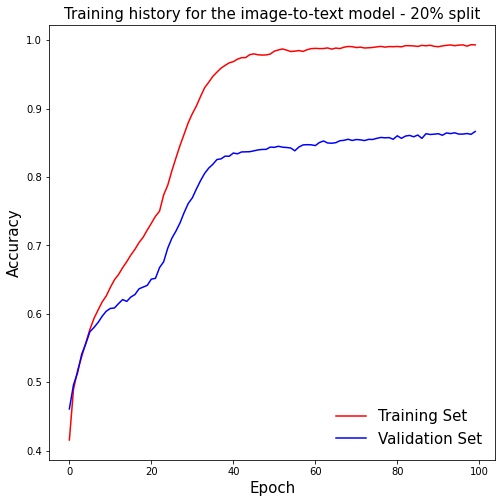

In [ ]:
#plotting the training history of the model
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(history.history['accuracy'], color = 'red', label = 'Training Set')
ax.plot(history.history['val_accuracy'], color = 'blue', label = 'Validation Set')
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_title('Training history for the image-to-text model - 20% split', fontsize = 15)
ax.legend(frameon = False, fontsize = 15)
#plt.savefig('image2text_0.2_split.pdf')
plt.show()


---
---

# 3. Text to image RNN Model

Hint: to make this model work well you will need deconvolutional layers in your decoder (look up ***Conv2DTranspose*** layer). To connect this from a flat latent vector you will also need an operation which is opposite to a ***Flatten*** layer that you usually use in convolutional architectures - for this look up the ***Reshape*** layer.

The goal here is to use X_text as inputs and y_img as outputs.

In [ ]:
#create a neural network which can convert the result images into strings  
#-> we use this network later to assess the accuracy of teh text-to-image network

i2t = tf.keras.Sequential()
i2t.add(LSTM(256, input_shape=(max_answer_length, 784)))
i2t.add(RepeatVector(max_answer_length))
i2t.add(LSTM(128, return_sequences=True))
i2t.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
i2t.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

i2t.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               1065984   
                                                                 
 repeat_vector (RepeatVector  (None, 4, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 4, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 4, 13)            1677      
 ibuted)                                                         
                                                                 
Total params: 1,264,781
Trainable params: 1,264,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#again we need to flatten the images in order to train this model
train = y_img_train.flatten().reshape(64000, 4, 784)
test = y_img_test.flatten().reshape(16000, 4, 784)

history = i2t.fit(train, y_text_onehot_train, epochs = 100, batch_size = 256, validation_data = (test, y_text_onehot_test))

Epoch 1/100
250/250 [==============================] - 15s 28ms/step - loss: 0.6767 - accuracy: 0.7862 - val_loss: 0.2455 - val_accuracy: 0.9347
Epoch 2/100
250/250 [==============================] - 5s 22ms/step - loss: 0.1572 - accuracy: 0.9590 - val_loss: 0.1163 - val_accuracy: 0.9688
Epoch 3/100
250/250 [==============================] - 5s 22ms/step - loss: 0.0826 - accuracy: 0.9775 - val_loss: 0.0818 - val_accuracy: 0.9775
Epoch 4/100
250/250 [==============================] - 5s 21ms/step - loss: 0.0524 - accuracy: 0.9855 - val_loss: 0.0601 - val_accuracy: 0.9823
Epoch 5/100
250/250 [==============================] - 5s 22ms/step - loss: 0.0336 - accuracy: 0.9909 - val_loss: 0.0510 - val_accuracy: 0.9847
Epoch 6/100
250/250 [==============================] - 5s 21ms/step - loss: 0.0215 - accuracy: 0.9945 - val_loss: 0.0454 - val_accuracy: 0.9864
Epoch 7/100
250/250 [==============================] - 5s 21ms/step - loss: 0.0141 - accuracy: 0.9967 - val_loss: 0.0412 - val_accuracy

KeyboardInterrupt: ignored

In [ ]:
# Your code
#architecture of the text-to-image model

text2image = tf.keras.Sequential()
text2image.add(LSTM(64, input_shape=(max_query_length, len(unique_characters))))
text2image.add(RepeatVector(4))
text2image.add(TimeDistributed(Dense(28*28, activation = 'relu')))
text2image.add(LSTM(36, return_sequences=True))
text2image.add(Reshape((4, 6, 6, 1)))
text2image.add(TimeDistributed(Conv2DTranspose(32, 23, activation = 'sigmoid')))
text2image.add(TimeDistributed(Conv2D(32, 1, activation = 'sigmoid')))

text2image.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


text2image.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19968     
                                                                 
 repeat_vector (RepeatVector  (None, 4, 64)            0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 4, 784)           50960     
 ibuted)                                                         
                                                                 
 lstm_1 (LSTM)               (None, 4, 36)             118224    
                                                                 
 reshape (Reshape)           (None, 4, 6, 6, 1)        0         
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 28, 28, 32)    1

In [ ]:
history = text2image.fit(X_text_onehot_train, y_img_train[:, :, :, :, np.newaxis], epochs = 200, validation_data = (X_text_onehot_test, y_img_test[:, :, :, :, np.newaxis]))

Epoch 1/200
2000/2000 [==============================] - 50s 23ms/step - loss: 0.2221 - accuracy: 0.0074 - val_loss: 0.2014 - val_accuracy: 0.0124
Epoch 2/200
2000/2000 [==============================] - 45s 23ms/step - loss: 0.1969 - accuracy: 0.0106 - val_loss: 0.1926 - val_accuracy: 0.0121
Epoch 3/200
2000/2000 [==============================] - 46s 23ms/step - loss: 0.1884 - accuracy: 0.0082 - val_loss: 0.1749 - val_accuracy: 0.0042
Epoch 4/200
2000/2000 [==============================] - 46s 23ms/step - loss: 0.1709 - accuracy: 0.0051 - val_loss: 0.1682 - val_accuracy: 0.0037
Epoch 5/200
2000/2000 [==============================] - 47s 23ms/step - loss: 0.1663 - accuracy: 0.0062 - val_loss: 0.1648 - val_accuracy: 0.0103
Epoch 6/200
2000/2000 [==============================] - 46s 23ms/step - loss: 0.1639 - accuracy: 0.0168 - val_loss: 0.1633 - val_accuracy: 0.0175
Epoch 7/200
2000/2000 [==============================] - 45s 23ms/step - loss: 0.1627 - accuracy: 0.0135 - val_loss: 0

In [ ]:
#our final models
i2t = keras.models.load_model('/content/gdrive/MyDrive/i2t.h5')
text2image = keras.models.load_model('/content/gdrive/MyDrive/text2image_model_2.h5')

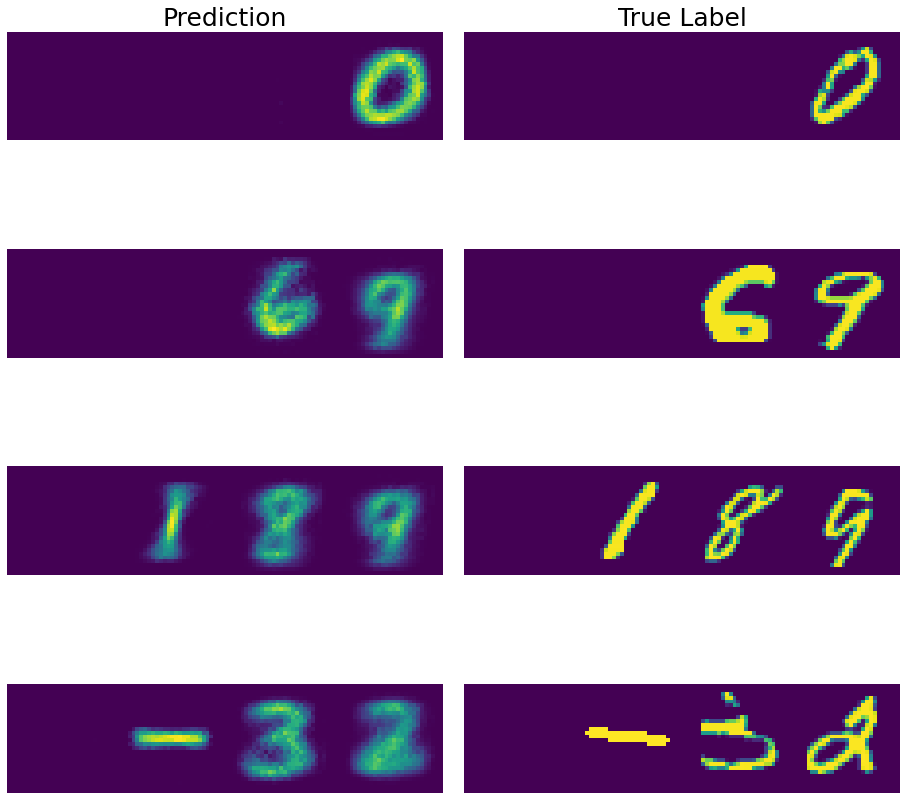

In [ ]:
#perform predictions using the text-to-image model
index = 301, 1, 2, 3
index = 301, 20, 44, 881
fig, ax = plt.subplots(4, 2, figsize = (16, 16)) 
#fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0.05)
ax[0, 0].set_title('Prediction', fontsize = 25)
ax[0, 1].set_title('True Label', fontsize = 25)
for i, j in zip(index, range(4)):
  ax[j, 0].axis('off')
  ax[j, 1].axis('off')
  ax[j, 0].imshow(np.hstack(pred[i]))
  ax[j, 1].imshow(np.hstack(y_true[i]))

#plt.savefig('image_pred.pdf', bbox_inches='tight',pad_inches = 0)
plt.show()

In [ ]:
#we now assess the accuracy of the text-to-image network using our image-to-text network we trained before

#Note: cannot use the entire test set for the predictions due to the limited RAM of google colab... (hence only 10000)
y_true = y_img_test[:10000]   #the true labels
pred = text2image.predict(X_text_onehot_test[:10000])[:, :, :, :, 0] #predictions in the form of sequence of images

pred_flattened = pred.flatten().reshape(10000, 4, 784)  #we need to flatten the sequence of images in order to feed it to the image-to-text network
pred_text = i2t.predict(pred_flattened) #prediction in the form of text

In [ ]:
#we now assess the accuracy of the text-to-image network

count_acc = 0   #this will compute the accuracy of the network
count_err = 0   #this will compute the average error of the network

for j, i in enumerate(pred_text):
  prediction = int(decode_labels(i))
  true = int(y_text[j])
  delta = prediction - true
  if delta == 0:
    count_acc += 1
  else:
    count_err += delta

print('Accuracy: ', count_acc / 10000)
print('Average error: ', count_err / 10000) 

Accuracy:  0.6716
Average error:  3.0686
